#  BREAST CANCER DATASET - BINARY CLASSIFICATION PREDICTION
- Date:  9/25/2024
- Author:  Bill Louer
- Datasource:  https://www.kaggle.com/datasets/yasserh/breast-cancer-dataset/data

##  Table of Contents
1.  [Project Overview](#section-1) 
2.  [Data Input](#section-2)
3.  [Data Cleaning](#section-3)
4.  [Exploratory Data Analysis](#section-4)
5.  [Feature Engineering](#section-5)
6.  [Modeling and Evaluation](#section-6)
7.  [Findings and Conclusions](#section-7)

##  1. Project Overview <a class="anchor" id="section-1"></a>

###  Background:  
Breast cancer is the most common cancer amongst women in the world. It accounts for 25% of all cancer cases, and affected over 2.1 Million people in 2015 alone. It starts when cells in the breast begin to grow out of control. These cells usually form tumors that can be seen via X-ray or felt as lumps in the breast area.

The key challenges against it’s detection is how to classify tumors into malignant (cancerous) or benign(non cancerous)

The objective of this project is to analyze these tumors using machine learning to classify the tumors into benign or malignant tumors.  

#### Dataset source:  https://www.kaggle.com/datasets/yasserh/breast-cancer-dataset/data
##### Data Contents:
- The dataset was downloaded from Kaggle and was referred to as the Breast Cancer Wisconsin (Diagnostic) Dataset.
  - Unique ID:  Unique incidence of data.
  - Diagnosis: Indicates whether the tumor is malignant (M) or benign (B). This is the target variable, used to classify the tumor type based on other features.
  - Radius Mean:  The average distance from the center to the perimeter of the tumor lobes. A larger radius may indicate a more aggressive or irregular tumor.
  - Texture Mean:  The average variation in the grayscale intensity of the tumor's surface texture. This feature could relate to the heterogeneity of the tumor, with more variable textures potentially indicating malignancy.
  - Perimeter Mean:  The average measurement around the boundary of the tumor lobes. A larger perimeter could signify irregular or more invasive tumor growth.
  - Area Mean:  The average area covered by the tumor lobes. Larger areas may be associated with more advanced or invasive tumors.
  - Smoothness Mean:  The average measure of how smooth or regular the edges of the tumor are. Lower smoothness might suggest more irregular tumor boundaries, which could indicate malignancy.
  - Compactness Mean:  Calculated as the square of the perimeter divided by the area, it measures how tightly packed the tumor cells are. A higher compactness may indicate more aggressive tumor behavior.
  - Concavity Mean:  The average extent of concave (inward) regions along the tumor boundary. More concavity may suggest irregular, invasive tumor growth.
  - Concave Points Mean:  The average number of concave points on the tumor boundary. More concave points are often associated with more irregular tumor shapes, which could be an indicator of malignancy.

In [1]:
#  import libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve
from sklearn import svm
from sklearn.model_selection import GridSearchCV

In [2]:
# Set pandas display precision for floats
pd.set_option('display.precision', 3)  # Set to 2 decimal places

## 2. Data Input <a class="anchor" id="section-2"></a>

In [3]:
data_filepath = '../data/raw/breast-cancer.csv'
df_tumors = pd.read_csv(data_filepath)

In [4]:
df_tumors.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.118,0.278,0.300,0.147,...,25.38,17.33,184.60,2019.0,0.162,0.666,0.712,0.265,0.460,0.119
1,842517,M,20.57,17.77,132.90,1326.0,0.085,0.079,0.087,0.070,...,24.99,23.41,158.80,1956.0,0.124,0.187,0.242,0.186,0.275,0.089
2,84300903,M,19.69,21.25,130.00,1203.0,0.110,0.160,0.197,0.128,...,23.57,25.53,152.50,1709.0,0.144,0.424,0.450,0.243,0.361,0.088
3,84348301,M,11.42,20.38,77.58,386.1,0.142,0.284,0.241,0.105,...,14.91,26.50,98.87,567.7,0.210,0.866,0.687,0.258,0.664,0.173
4,84358402,M,20.29,14.34,135.10,1297.0,0.100,0.133,0.198,0.104,...,22.54,16.67,152.20,1575.0,0.137,0.205,0.400,0.163,0.236,0.077


In [5]:
df_tumors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [6]:
#  Set up miscellaneous function so I can print dataframe tables for the report or presentation.
# This function requires work.  I need to format data columns with the appropriate number of significant digits before printing.
def print_table(df, sheetname):
    filepath = '../reports/results.xlsx'
    if os.path.exists(filepath):
        with pd.ExcelWriter(filepath, mode='a', engine='openpyxl', if_sheet_exists='new') as writer:
            # Write DataFrame to a new sheet
            df.to_excel(writer, sheet_name=sheetname, index=False,  float_format="%.3f")
    else:
        with pd.ExcelWriter(filepath, mode='w', engine='openpyxl',) as writer:
            # Write DataFrame to a new sheet
            df.to_excel(writer, sheet_name=sheetname, index=False, float_format="%.3f")


## 3.  Data Cleaning <a class="anchor" id="section-3"></a>

In [7]:
df_tumors.dtypes

id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst     

In [8]:
#  check for NaN values
print('Number of NaN Values for Each Feature:')
df_tumors.isna().sum()

Number of NaN Values for Each Feature:


id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

In [9]:
#  check for duplicate rows of data
print(f'Number of Duplicate Rows of Data:  {df_tumors.duplicated().sum()}')

Number of Duplicate Rows of Data:  0


In [10]:
df_tumors.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [11]:
#  Check for number of unique categories in diagnosis column
df_tumors.diagnosis.unique()

array(['M', 'B'], dtype=object)

In [12]:
#  Check for unbalanced data (is diagnosis more common for one category than another?)
df_tumors['diagnosis'].value_counts()

diagnosis
B    357
M    212
Name: count, dtype: int64

In [13]:
#  Convert target variable to binary value using map function
df_tumors['diagnosis_M'] = df_tumors['diagnosis'].map({'M': 1, 'B': 0})

## 4. Exploratory Data Analysis <a class="anchor" id="section-4"></a>

In [14]:
#  Perform descriptive statistics on the data
df_tumors.describe(include='all')

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis_M
count,5.690e+02,569,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000,...,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000
unique,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,3.037e+07,NaN,14.127,19.290,91.969,654.889,0.096,0.104,0.089,0.049,...,25.677,107.261,880.583,0.132,0.254,0.272,0.115,0.290,0.084,0.373
std,1.250e+08,NaN,3.524,4.301,24.299,351.914,0.014,0.053,0.080,0.039,...,6.146,33.603,569.357,0.023,0.157,0.209,0.066,0.062,0.018,0.484
min,8.670e+03,NaN,6.981,9.710,43.790,143.500,0.053,0.019,0.000,0.000,...,12.020,50.410,185.200,0.071,0.027,0.000,0.000,0.157,0.055,0.000
25%,8.692e+05,NaN,11.700,16.170,75.170,420.300,0.086,0.065,0.030,0.020,...,21.080,84.110,515.300,0.117,0.147,0.115,0.065,0.250,0.071,0.000
50%,9.060e+05,NaN,13.370,18.840,86.240,551.100,0.096,0.093,0.062,0.034,...,25.410,97.660,686.500,0.131,0.212,0.227,0.100,0.282,0.080,0.000
75%,8.813e+06,NaN,15.780,21.800,104.100,782.700,0.105,0.130,0.131,0.074,...,29.720,125.400,1084.000,0.146,0.339,0.383,0.161,0.318,0.092,1.000


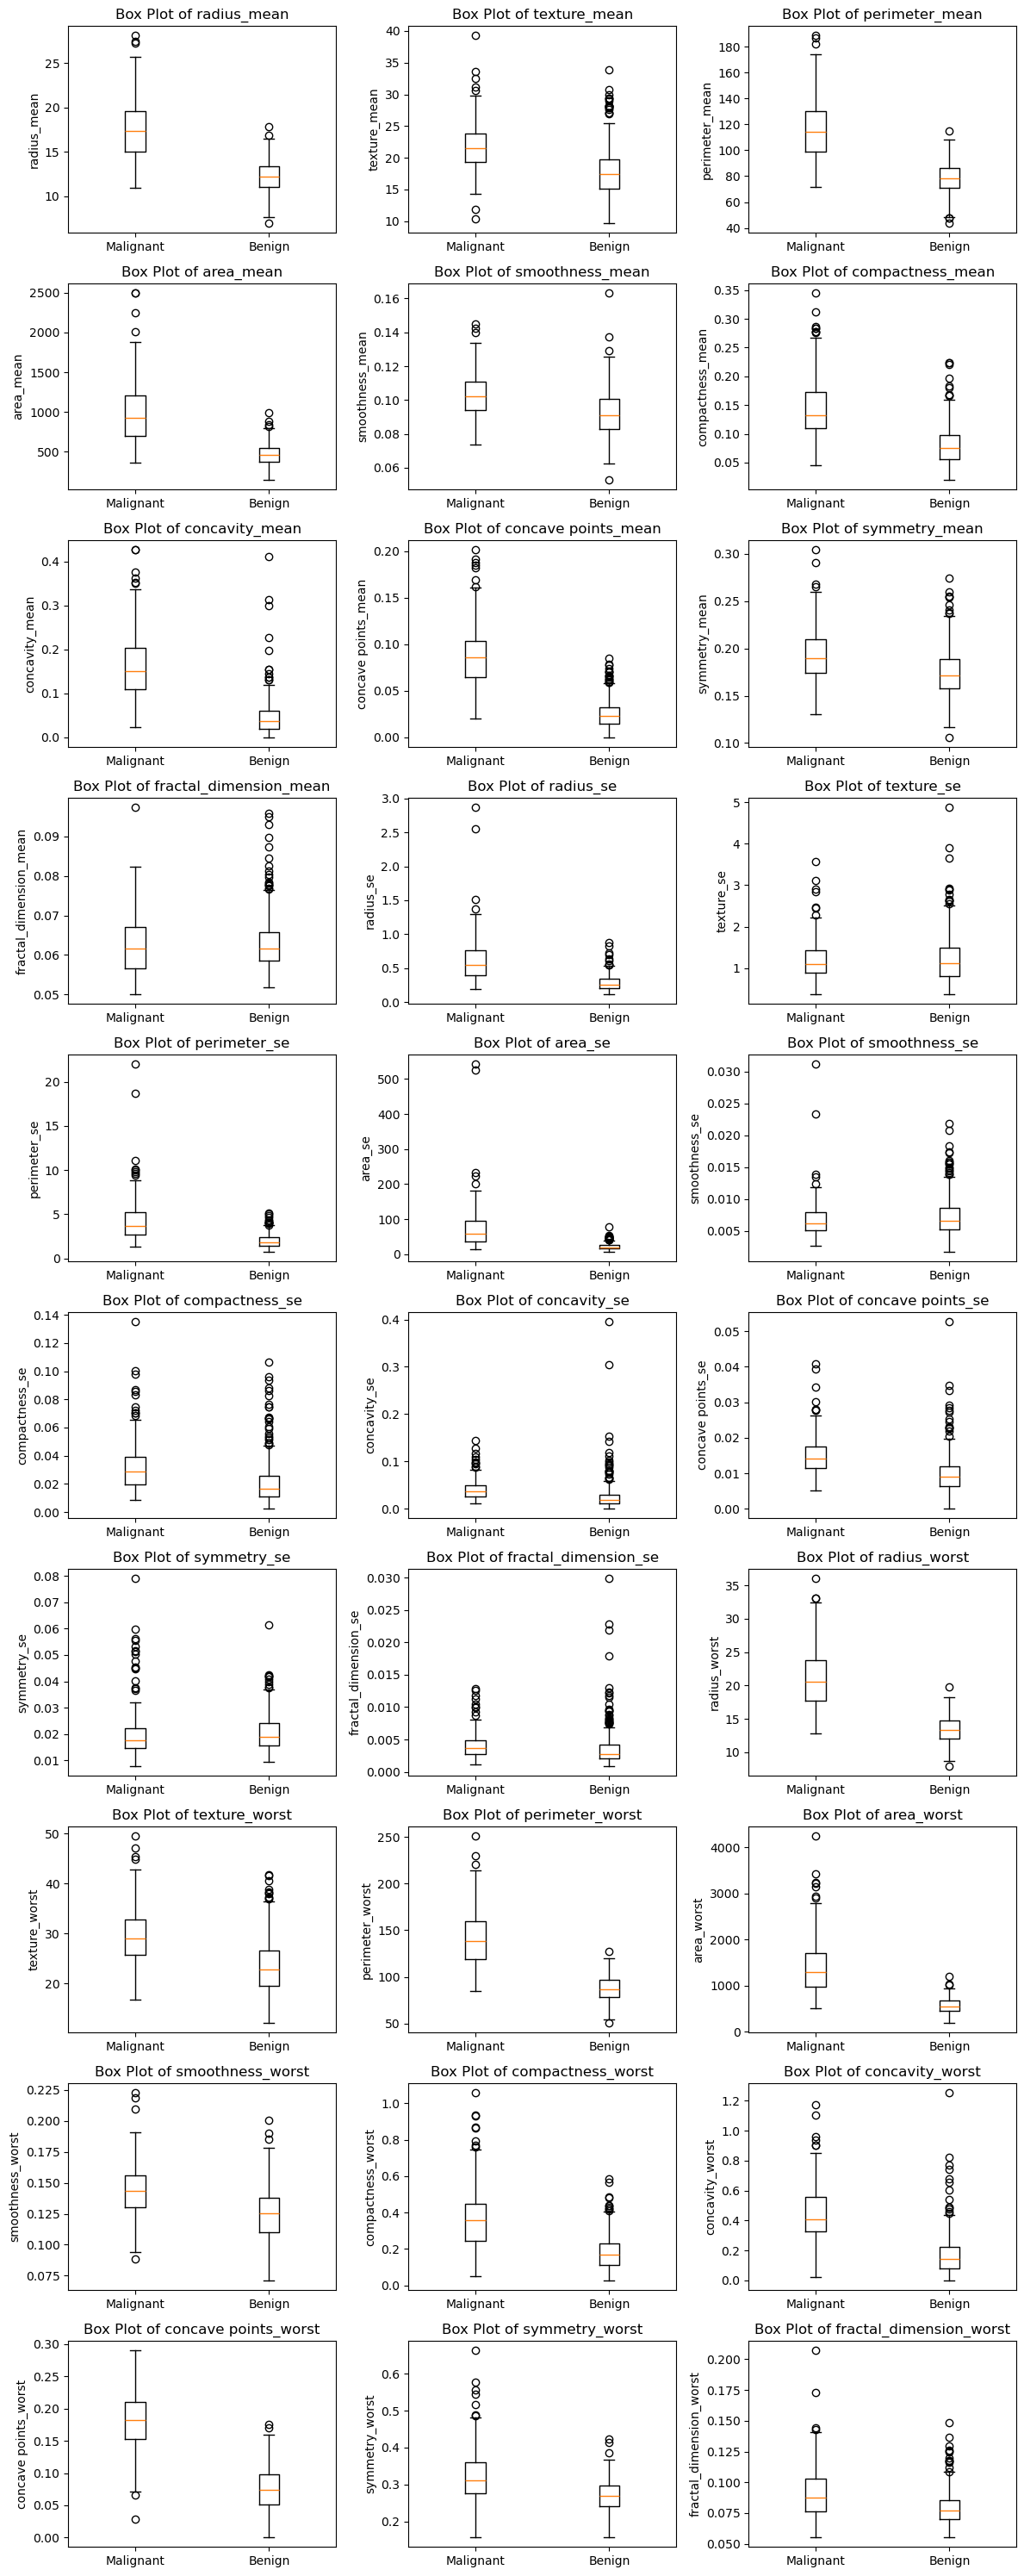

In [15]:
# Produce and save boxplots to show the distribution of each variables data for both benign and malignant tumors.  Show where they may be outliers.
feature_columns = ['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst']

plot_columns = 3
plot_rows = (len(feature_columns) // plot_columns) 
fig, axs = plt.subplots(plot_rows, plot_columns, figsize = (12,30))
axs = axs.flatten() #  turns the 2D array of axes into a 1D list, which makes iterating through them easier.

for i, col in enumerate(feature_columns):
    axs[i].boxplot([df_tumors[df_tumors['diagnosis'] == 'M'][col], df_tumors[df_tumors['diagnosis'] == 'B'][col]],labels=['Malignant', 'Benign'])
    axs[i].set_title(f'Box Plot of {col}')
    axs[i].set_ylabel(col)

plt.tight_layout()
plt.show()


In [16]:
Q1 = df_tumors[feature_columns].quantile(0.25)
Q3 = df_tumors[feature_columns].quantile(0.75)
IQR = Q3 - Q1
IQR
outliers = df_tumors[(df_tumors[feature_columns] < (Q1 - 1.5 * IQR)) | (df_tumors[feature_columns] > (Q3 + 1.5 * IQR))]
print(f'Rows with at least one outlier:  {len(df_tumors) - outliers.isna().all(axis=1).sum()}')
print(f'Columns with the most outliers:\n{outliers.notna().sum().sort_values(ascending=False)}')

Rows with at least one outlier:  171
Columns with the most outliers:
area_se                    65
perimeter_se               38
radius_se                  38
area_worst                 35
smoothness_se              30
compactness_se             28
fractal_dimension_se       28
symmetry_se                27
area_mean                  25
fractal_dimension_worst    24
symmetry_worst             23
concavity_se               22
texture_se                 20
concave points_se          19
concavity_mean             18
radius_worst               17
compactness_worst          16
compactness_mean           16
perimeter_worst            15
fractal_dimension_mean     15
symmetry_mean              15
radius_mean                14
perimeter_mean             13
concavity_worst            12
concave points_mean        10
smoothness_worst            7
texture_mean                7
smoothness_mean             6
texture_worst               5
id                          0
concave points_worst        0
d

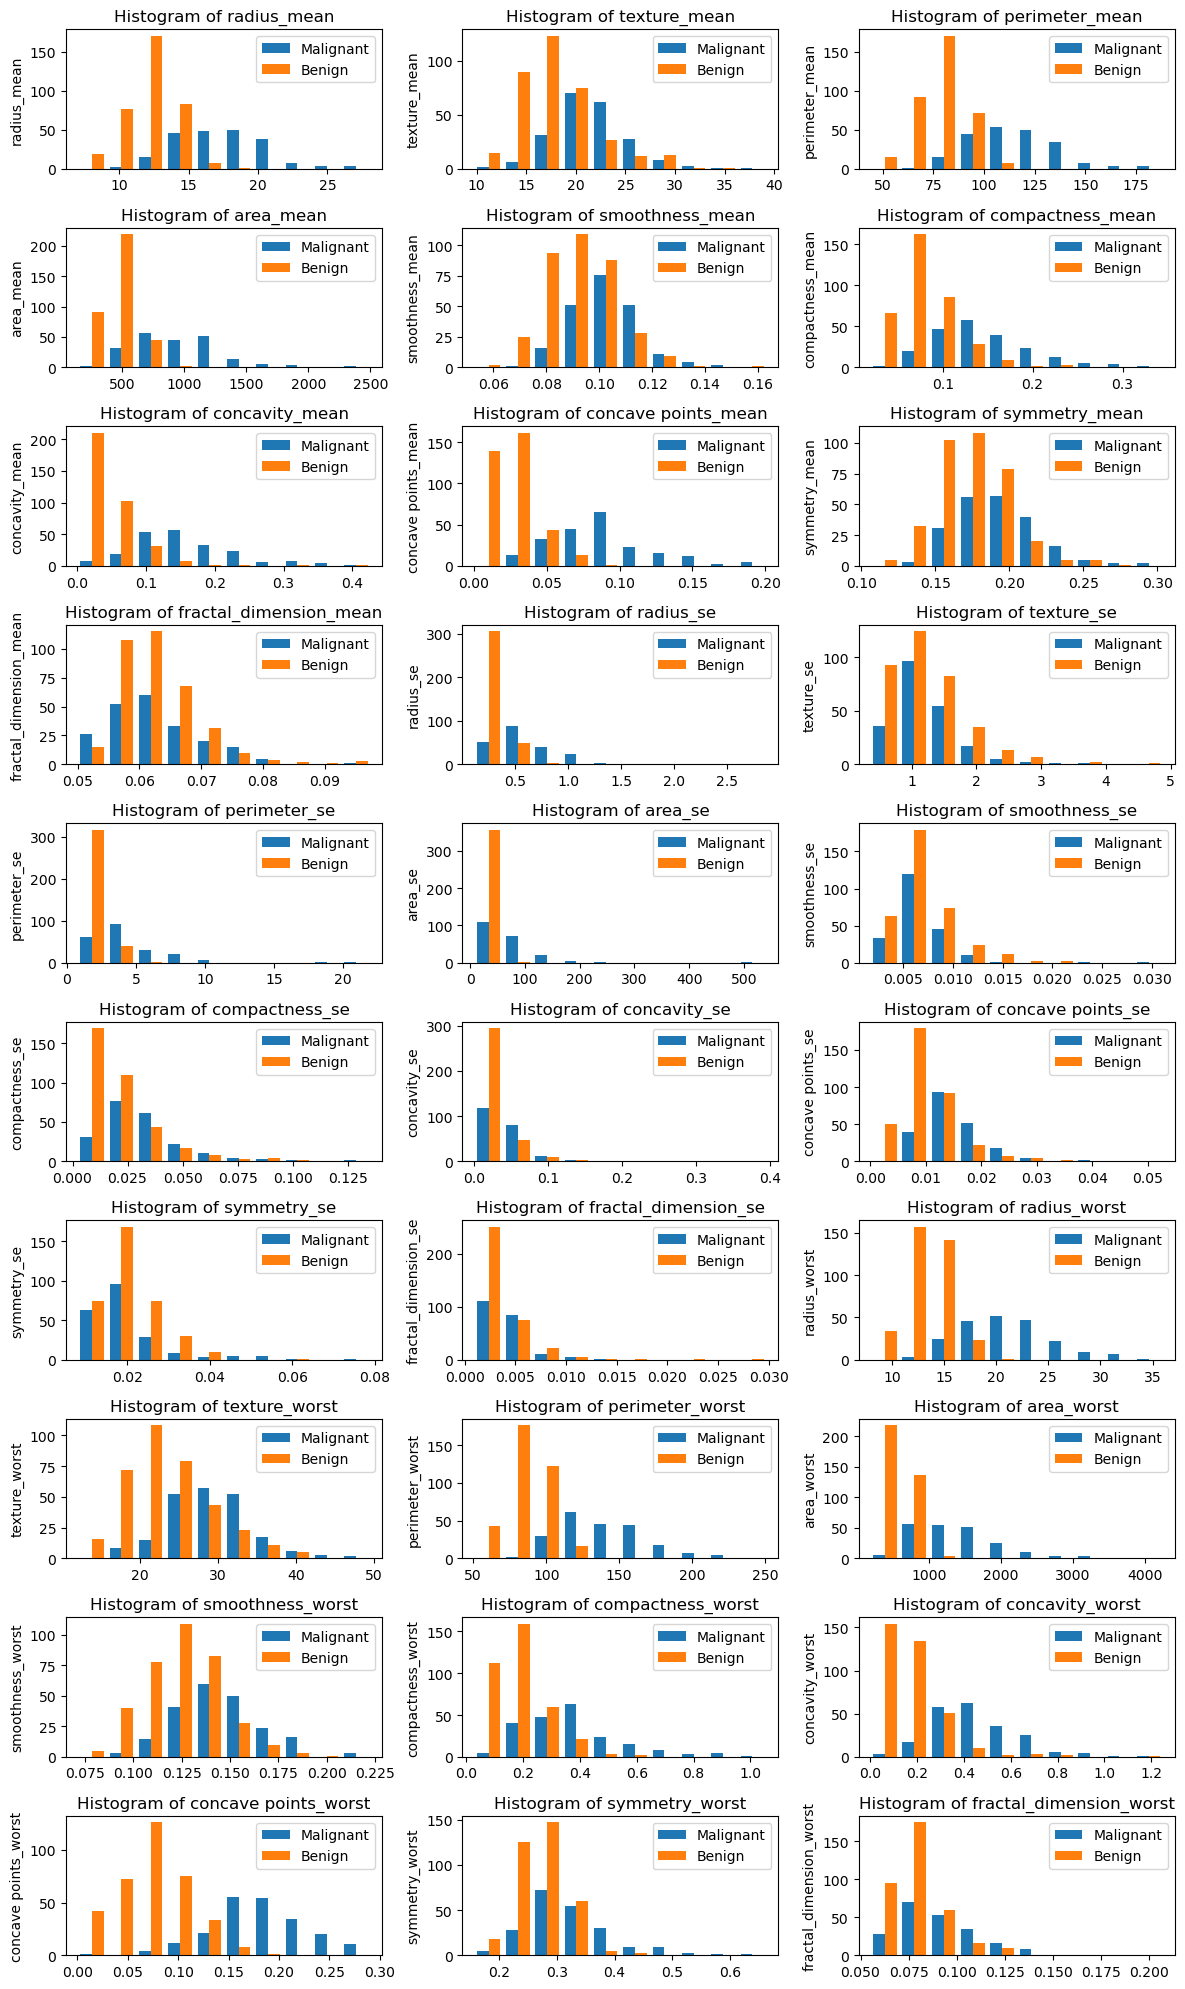

In [17]:
#  Create a histogram of each variable

plot_columns = 3
plot_rows = (len(feature_columns) // plot_columns) 
fig, axs = plt.subplots(plot_rows, plot_columns, figsize = (12,20))
axs = axs.flatten() #  turns the 2D array of axes into a 1D list, which makes iterating through them easier.

for i, col in enumerate(feature_columns):
    axs[i].hist([df_tumors[df_tumors['diagnosis'] == 'M'][col], df_tumors[df_tumors['diagnosis'] == 'B'][col]],label=['Malignant', 'Benign'])
    axs[i].set_title(f'Histogram of {col}')
    axs[i].set_ylabel(col)
    axs[i].legend()
plt.tight_layout()
plt.show()

In [18]:
#  Check if columns have low variance, whether the columns have the same value throughout.
low_variance_columns = df_tumors[feature_columns].columns[df_tumors[feature_columns].nunique() <= 1]
print(f'Number of low variance columns:  {len(low_variance_columns)}')

Number of low variance columns:  0


#### Save the cleaned  data to a new csv file.

In [19]:
filepath = '../data/interim/breast_cancer_interim.csv'
df_tumors.to_csv(filepath, index=False )

## 5. Feature Engineering <a class="anchor" id="section-5"></a>

### Evaluating Correlation between feature and target variables.
-  Point Biserial Correlation:
    - Special case of the pearson correlation that measures the relationship between continuous variable and a binary target variable.
    - It assesses how the mean of a numberical variable differs across the two categories of a binary variable. 

In [20]:
# Investigate the correlation between the continuous feature variables and the categorical target variable.
y_col = 'diagnosis_M'
x_vars, y_vars, corr_coefs, p_vals = [], [], [], []
for col in feature_columns:
    x_vars.append(col)
    y_vars.append('Malignant')
    coef, p_val = pointbiserialr(df_tumors[col], df_tumors[y_col])
    corr_coefs.append(coef)
    p_vals.append(p_val)
df_corr_p_val = pd.DataFrame({'x_variable': x_vars, 'y_variable':y_vars, 'correlation_coef': corr_coefs, 'p_value': p_vals}).sort_values('p_value', ascending=True)
df_corr_p_val

,x_variable,y_variable,correlation_coef,p_value
27,concave points_worst,Malignant,0.794,1.969e-124
22,perimeter_worst,Malignant,0.783,5.771e-119
7,concave points_mean,Malignant,0.777,7.101e-116
20,radius_worst,Malignant,0.776,8.482e-116
2,perimeter_mean,Malignant,0.743,8.436e-101
23,area_worst,Malignant,0.734,2.829e-97
0,radius_mean,Malignant,0.730,8.466e-96
3,area_mean,Malignant,0.709,4.735e-88
6,concavity_mean,Malignant,0.696,9.967e-84
26,concavity_worst,Malignant,0.660,2.465e-72


In [21]:
corr_p_val_filter = (df_corr_p_val['correlation_coef'] > 0.5) & (df_corr_p_val['p_value'] < 0.01)
features_screen1 = df_corr_p_val[corr_p_val_filter]
features_screen1

,x_variable,y_variable,correlation_coef,p_value
27,concave points_worst,Malignant,0.794,1.969e-124
22,perimeter_worst,Malignant,0.783,5.771e-119
7,concave points_mean,Malignant,0.777,7.101e-116
20,radius_worst,Malignant,0.776,8.482e-116
2,perimeter_mean,Malignant,0.743,8.436e-101
23,area_worst,Malignant,0.734,2.829e-97
0,radius_mean,Malignant,0.730,8.466e-96
3,area_mean,Malignant,0.709,4.735e-88
6,concavity_mean,Malignant,0.696,9.967e-84
26,concavity_worst,Malignant,0.660,2.465e-72


### Above feature variables are highly correlated to the target variable.  
- Check whether any of these variables are collinearly related to each other.

Highly correlated pairs:
('concave points_worst', 'concave points_mean')
('perimeter_worst', 'radius_worst')
('perimeter_worst', 'perimeter_mean')
('perimeter_worst', 'area_worst')
('perimeter_worst', 'radius_mean')
('perimeter_worst', 'area_mean')
('concave points_mean', 'concavity_mean')
('radius_worst', 'perimeter_mean')
('radius_worst', 'area_worst')
('radius_worst', 'radius_mean')
('radius_worst', 'area_mean')
('perimeter_mean', 'area_worst')
('perimeter_mean', 'radius_mean')
('perimeter_mean', 'area_mean')
('area_worst', 'radius_mean')
('area_worst', 'area_mean')
('radius_mean', 'area_mean')
('radius_se', 'perimeter_se')
('radius_se', 'area_se')
('perimeter_se', 'area_se')


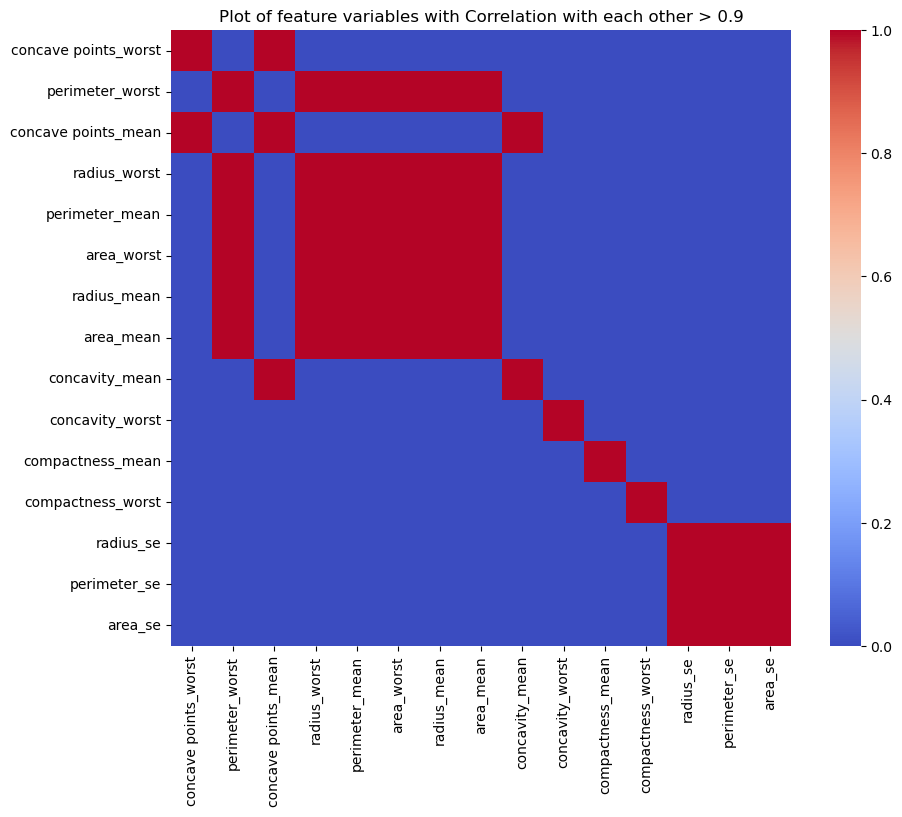

In [22]:
features_screened = list(features_screen1.x_variable)
threshold = 0.90
co_linear = df_tumors[features_screened].corr() > threshold
plt.figure(figsize=(10,8))
sns.heatmap(co_linear, annot=False, cmap='coolwarm')
plt.title('Plot of feature variables with Correlation with each other > 0.9')
#  
corr_matrix = df_tumors[features_screened].corr()
high_corr_features = np.where(np.abs(corr_matrix) > threshold)
high_corr_pairs = [(corr_matrix.index[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_features) if x != y and x < y]

# Print highly correlated feature pairs
print("Highly correlated pairs:")
for pair in high_corr_pairs:
    print(pair)

###  Observations on potential Multicollinear variables:
-  radius_mean, perimeter_mean, and area_mean appear to be co-linear (makes sense).
-  radius_mean and radius_worst also seems co-dependent with radius_worst and perimeter_worst
-  radius_se are also co-dependent with perimeter_se and area_se.
-  Conclusion:  Use radius_mean and radius_se only and disregard all perimeter or area features.  Run model with and without these features to see the effect.

In [23]:
#  Select the features which have a high correlation with target variable (> .50), low p_value (< 0.01) and do not show collinearity (collineararity > 0.90) with other features.
features_screened_d = ['concave points_worst','perimeter_worst', 'concavity_mean', 'concavity_worst', 'compactness_mean', 'compactness_worst']

#### Save the cleaned and featured data to a new csv file.

In [24]:
filepath = '../data/interim/breast_cancer_interim.csv'
df_tumors.to_csv(filepath, index=False )

####  Create training and testing sets and then scale the feature variables in the data using standard scalar.

In [25]:
#  Create training and testing sets and then scale the feature variables. 
#  Doing this in this order prevents data leakage (test data leaking into training the model.)
y = df_tumors['diagnosis_M']
X = df_tumors[features_screened_d]
X_train, X_test, y_train,  y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled =  scaler.transform(X_test)

## 6. Modeling and Evaluation <a class="anchor" id="section-6"></a>

##  Functions for plotting the model validation results

In [26]:
#  plot a confusion matrix when given the actual y_test and Y_predicted
def plot_confusion_matrix(y_test, y_predict):
    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_predict)
    #  plot confusion matrix
    
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    
    # Step 3: Add labels, title, and axis names
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    # Step 4: Show the plot
    plt.show()

###  Logistic Regression Model
###  Logistic Regression has the following attributes and algorithm summary:
#### Attributes and Advantages:
-  Predicts a binary categorical variable.
-  Feature variables can be continuous or categorical.
-  Can predict the probability of the prediction belonging to a certain class.
-  Useful when we want to know the impact of a feature on teh target categorical variable.
#### Algorithm Summary:
-  Parameters are initialized randomly.
-  Feed the cost function with the training set and calculate the error.
-  Calculate the gradient of the cost function.
-  Update the weights on the new values.
-  Repeat process until cost is within threshold.
-  Predict the target variable and probability.


In [27]:
log_regr_model = LogisticRegression()
log_regr_model.fit(X_train_scaled, y_train)
y_predict = log_regr_model.predict(X_test_scaled)

In [28]:
#  Evaluate model accuracy and confusion matrix
accuracy = accuracy_score(y_test, y_predict)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.96


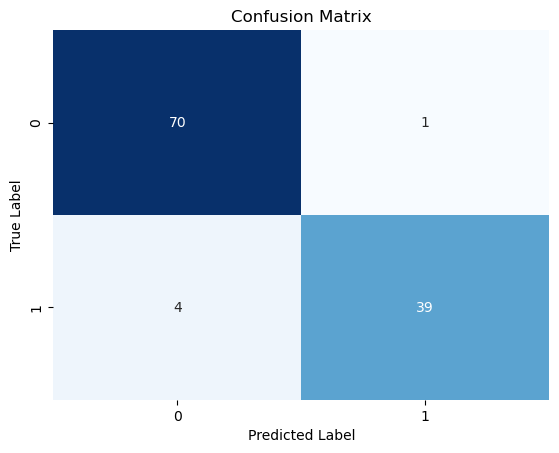

In [29]:
plot_confusion_matrix(y_test, y_predict)

In [30]:
# Classification report
class_report = classification_report(y_test, y_predict)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97        71
           1       0.97      0.91      0.94        43

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



#### Using GridSearch to tune the hyperparameters

In [31]:
# Create the logistic regression model
log_regr_model_grid = LogisticRegression()

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear'],  # Based on penalty choice
    'max_iter': [100, 200, 300],
    'class_weight': [None, 'balanced']
}

# Set up GridSearchCV with cross-validation
grid_search = GridSearchCV(log_regr_model_grid, param_grid, cv=5, scoring='accuracy')

# Fit the model to the data
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and the best score
print("Best parameters: ", grid_search.best_params_)
print("Best accuracy: ", grid_search.best_score_)

Best parameters:  {'C': 10, 'class_weight': 'balanced', 'max_iter': 100, 'solver': 'liblinear'}
Best accuracy:  0.9406593406593406


In [32]:
probabilities = grid_search.predict_proba(X_test_scaled)
# Example: Access probabilities for the positive class (malignant)
malignant_probabilities = probabilities[:, 1]

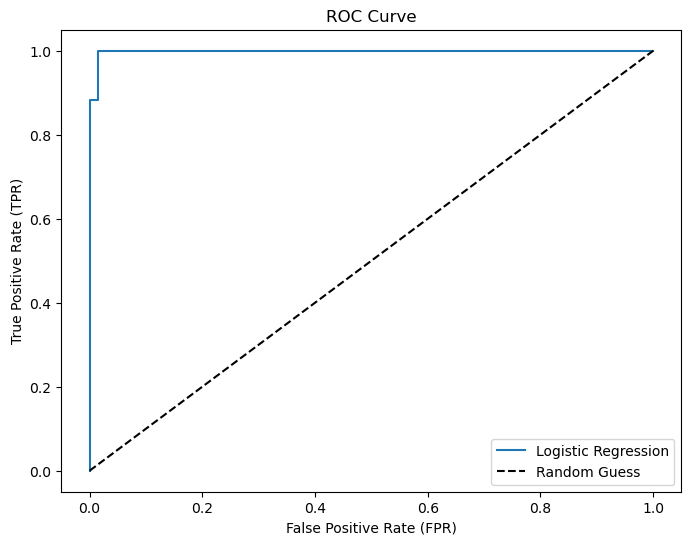

In [33]:
#  Use the Recieved Operating Characteristic Curve (ROC) The ROC curve plots the true positive rate against the false positive rate.
#  This helps distinguish how the model distinguishes between positive and negative cases.

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, malignant_probabilities)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Logistic Regression')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.show()

#### Precision Recall Curve:
-  This curve is useful when there are unbalanced classes (when malignant tumors are rare)
-  It plots precision vs. recall at different probability thresholds.

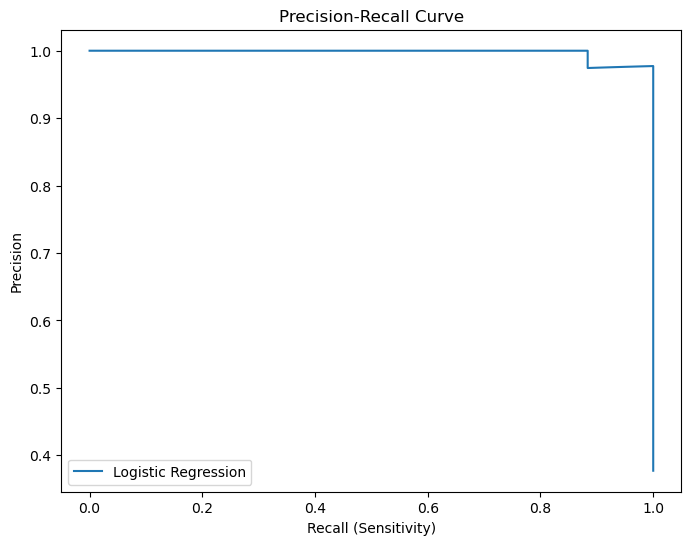

In [34]:
# Compute precision and recall for different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, malignant_probabilities)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Logistic Regression')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [35]:
y_predict_grid = grid_search.predict(X_test_scaled)
#  Evaluate model accuracy and confusion matrix
accuracy = accuracy_score(y_test, y_predict_grid)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9825


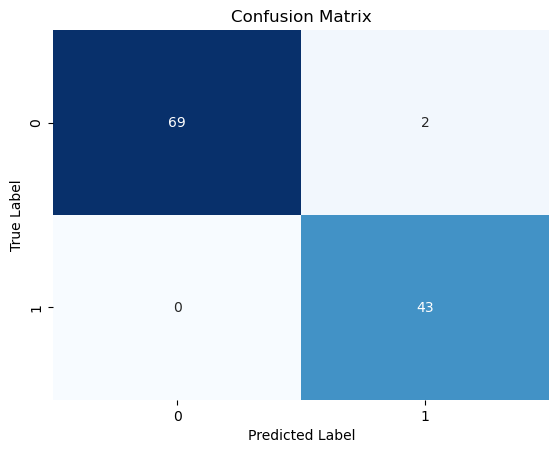

In [36]:
plot_confusion_matrix(y_test, y_predict_grid)

In [37]:
# Classification report
class_report = classification_report(y_test, y_predict_grid)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        71
           1       0.96      1.00      0.98        43

    accuracy                           0.98       114
   macro avg       0.98      0.99      0.98       114
weighted avg       0.98      0.98      0.98       114



Results from Logistic Regression:
- Precision of 0.98 means that 98% of predicted Malignant Tumors (total Predicted Positive) were in fact Malignant (True Positive).  2% false positives.
- Recall of 0.93 means 93% of actual Malignant Tumors were predicted as positive.  In other words the model did not predict 7% of actual positives as positve.

###  Support Vector Machine (SVM) Model
###  SVM has the following attributes and algorithm summary:
#### Attributes and Advantages:
-  Classifies cases by finding a separator

-  Prone to overfitting if the number of features >> samples
-  Not efficient for large datasets.
#### Algorithm Summary:
-  Transforms the data so that you can separate the target classes
-  The algorithm is looking for a hyperplane that maximizes the margin or separation between classes.


In [38]:
svm_model = svm.SVC()
svm_model.fit(X_train_scaled, y_train)
y_predict_svm = svm_model.predict(X_test_scaled)

In [39]:
#  Evaluate model accuracy and confusion matrix
accuracy = accuracy_score(y_test, y_predict_svm)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.96


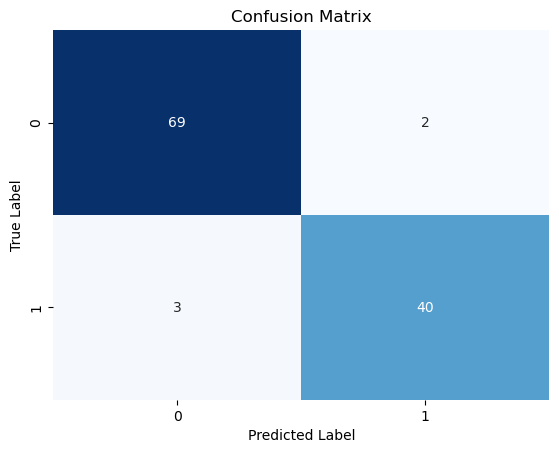

In [40]:
plot_confusion_matrix(y_test, y_predict_svm)

In [41]:
# Classification report
class_report = classification_report(y_test, y_predict_svm)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97        71
           1       0.95      0.93      0.94        43

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



In [42]:
# Define the model
svc_grid = svm.SVC()

# Define the parameter grid for tuning
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'degree': [2, 3, 4],  # Only relevant for 'poly' kernel
    'coef0': [0.0, 0.1, 0.5, 1],  # Relevant for 'poly' and 'sigmoid'
    'class_weight': [None, 'balanced'],
}

# Set up GridSearchCV
svc_grid_search = GridSearchCV(svc_grid, param_grid, cv=5, scoring='accuracy')

# Fit the model to the training data
svc_grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and the best score
print("Best parameters: ", svc_grid_search.best_params_)
print("Best accuracy: ", svc_grid_search.best_score_)

Best parameters:  {'C': 10, 'class_weight': None, 'coef0': 0.5, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
Best accuracy:  0.9648351648351647


In [43]:
y_predict_svm_grid = svc_grid_search.predict(X_test_scaled)
#  Evaluate model accuracy and confusion matrix
accuracy = accuracy_score(y_test, y_predict_svm_grid)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.96


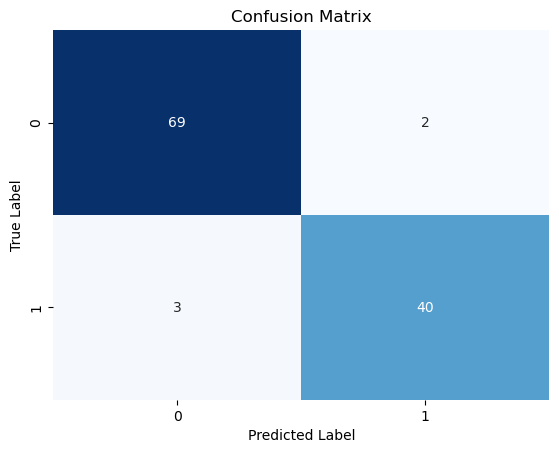

In [44]:
plot_confusion_matrix(y_test, y_predict_svm_grid)

In [45]:
# Classification report
class_report = classification_report(y_test, y_predict_svm_grid)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97        71
           1       0.95      0.93      0.94        43

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



# NEXT:
-  Evaluate collinearity of feature variables more.  What are the best feature variables?
-  Write a short letter report describing the report, results and next steps.  Use this to learn more about the models I used in this project.

## 7. Findings and Conclusions <a class="anchor" id="section-7"></a>

-  Tumor diagnostic data was analyzed for NaN values, duplicate entries and outliers.
-  Tumor feature variables were evaluated against the transformed target variable (diagnosis).
-  Leading feature variables were then evaluated against each other to evaluate multi-collinearity and to eliminate variables which may already be captured in the model.  A correlation threshold of 0.9 was used to eliminate variables which were correlated against each other.
-  The logistic regression model with Grid Search produced a test accuracy of 98% while the SVM model with grid search produced only a 96% accuracy.
-  The logistic regression model produced a precision score of 0.96 and a recall of 1.0 for predicting a malignant tumor.
-  The SVM model produced a precision of 0.95 and recall of 0.93 for predicing a malignant tumor.
-  While both models are very accurate, the logistic regression model was more accurate and with a recall of 1.0, this means that the predicted values were always predicting positives (no false negatives).  This is useful for a cancer diagnosis prediction because you do not want to miss a positive diagnosis with the model predicting a benign tumor when it is in fact malignant.
-  The cost of a false negative is much higher than the cost of a false positive.  While a false positive will give a patient more stress and could incur further testing costs (biopsy, scans, potential treatment), a false negative could incur a false sense of security in a patient and meanwhile the cancer could enlarge or progress further, which could be tragic. 

### Thoughts on Future Work and Next Steps:
-  More data could be available through the Wisconsin breast cancer database and/or we could supplement the existing training data with new data produced with generative AI.
-  If the data exists, we could further test the model.
-  Review the modeling from other kaggle users and see if there are model improvements that can be made.
-  Investigate the transparency of the model, so that I can explain the model to others.


###  Acknowledgements:
-  This work relies on data provided by Kaggle user M Yasser H. The data is greatly appreciated.

### IMPACTFUL BREAST CANCER CHARITIES

<img src='https://www.metavivor.org/_media/images/global/header/logo-tagline-2019.png' alt="Metavivor Logo" width="400" height="100" >
METAvivor is dedicated to the specific fight of patients living with stage 4 metastatic breast cancer. At the time of METAvivor’s founding, no organization was dedicated to funding research for the disease and no patient groups were speaking out about the dearth of stage 4 cancer research.  While more and more people have taken up the cry for more stage 4 research, METAvivor remains the sole US organization dedicated to awarding annual stage 4 breast cancer research.

Reference:  Metavivor logo (https://www.metavivor.org/)